# PDC

> Utilities to manipulate power duration curves, fit them and do what-if analysis

In [ ]:
#| default_exp pdc

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()

In [ ]:
#| export
from lmfit import Model, Parameters
import numpy as np
import pandas as pd

The power_curve function will be fitted to its parameters, with reasonable bounds

In [ ]:
#| export
def power_curve(x, 
                frc,  # Functional Reserve Capacity 
                ftp,  # Functional Threshold Power
                tte,  # Time to Exhaustion
                tau,  # Short end calibration
                tau2, # Long end calibration
                a): # Decay factor past TTE
    p = frc/x * (1.0 - np.exp(-x/tau)) + ftp * (1 - np.exp(-x / tau2))
    p -= np.maximum(0, a * np.log(x / tte))
    return p

In [ ]:
#| export
class PDC:
    "A Power Duraction Curve"
    def __init__(self, x, y): self.x, self.y = x, y
    
    def fit(self):
        gmodel = Model(power_curve)
        params = Parameters()
        params.add('frc', value=5000, min=1, max=15000)
        params.add('ftp', value=150, min=100, max=400)
        params.add('tte', value=2000, min=1800, max=3600)
        params.add('tau', value=12, min=10, max=25)
        params.add('tau2', value=5000, min=10, max=25)
        params.add('a', value=10, min=1, max=200)
        
        return gmodel.fit(self.y, params, x=self.x)
        
    

In [ ]:
show_doc(PDC)

---

### PDC

>      PDC (x, y)

A Power Duraction Curve

Load a mean maximal curve, with time in seconds and corresponding watts

In [ ]:
df = pd.read_csv("../data/mmpcurve.csv")
pdc = PDC(df['Secs'], df['Watts'])

In [ ]:
result = pdc.fit()

In [ ]:
result.best_values

{'frc': 10190.691792353007,
 'ftp': 247.97104270072407,
 'tte': 1800.0000561443576,
 'tau': 12.619522854826833,
 'tau2': 25.0,
 'a': 33.22731702525135}

In [ ]:
#| hide
import matplotlib.pyplot as plt

In [ ]:
fitted_curve = power_curve(pdc.x, result.best_values['frc'],
                          result.best_values['ftp'],
                          result.best_values['tte'],
                          result.best_values['tau'],
                          result.best_values['tau2'],
                          result.best_values['a'])


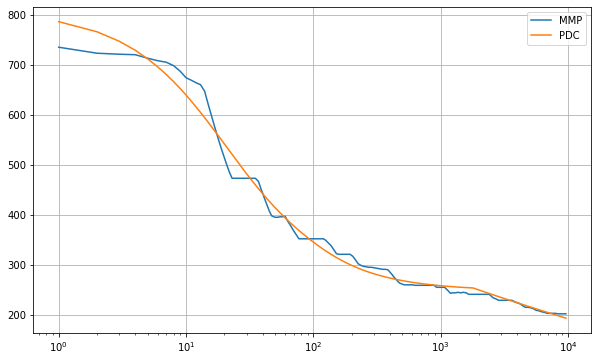

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(pdc.x, pdc.y, label='MMP')
plt.plot(pdc.x, fitted_curve, label='PDC')
plt.legend()
plt.grid(True)
plt.xscale('log')
plt.show()